#### 필요한 패키지 불러오기 

In [2]:
# 옵션설정 

import pandas as pd 
from openpyxl import load_workbook

# 시각화 패키지 불러오기 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy

from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


#### Tivo 엑셀파일 불러오기 

In [3]:
#kebob 엑셀 파일 불러오기 
#data_only=Ture로 해줘야 수식이 아닌 값으로 받아온다.
load_wb1 = load_workbook("desktop/tivo1.xlsx", data_only=True)

//anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
# 시트이름 불러오기 : Customer Survey 
load_ws1 = load_wb1["Survey Data"]

#### 엑셀시트 불러오기 

In [4]:
all_values1 = []
for row in load_ws1.rows:
    row_value = []
    for cell in row:
        row_value.append(cell.value)
    all_values1.append(row_value)

survey1 = pd.DataFrame(all_values1)

survey1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,Q1,demographic,X,demographic,demographic,demographic,None,demographic,demographic,demographic,...,None,purchasing,purchasing,purchasing,purchasing,purchasing,behavioral,behavioral,attitude,None
1,ID,Gender,Coded Gender,Marital Status,Work Status,Education,Ed coded,Annual Income (x1000 $),Age,Location,...,PL coded,Monthly Electronics Spend,Annual spending on electronics,Spending as % of income,Monthly Household Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),Favorite feature,FF coded


In [5]:
survey1 = survey1.rename(columns=survey1.iloc[0]).drop(0, axis = 0)

#### 컬럼 지정 
survey1에 첫번째행을 컬럼명으로 변경 => 첫번째행은 삭제 

In [6]:
survey1.columns = survey1.iloc[0,:].values
survey1 = survey1.drop(1)

### 1. 전처리 

#### 1.1 결측치 확인 및 제거 

In [7]:
pd.DataFrame(survey1.isna().mean())

,0
ID,0.05482
Gender,0.05482
Coded Gender,0.05482
Marital Status,0.05482
Work Status,0.05482
Education,0.05482
Ed coded,0.05482
Annual Income (x1000 $),0.05482
Age,0.05482
Location,0.05482


In [8]:
#제일 마지막행을 보면 모든 값들이 다 결측치 이므로 2행 모두 삭제해 주도록 한다. 
survey1.tail(2)

,ID,Gender,Coded Gender,Marital Status,Work Status,Education,Ed coded,Annual Income (x1000 $),Age,Location,...,PL coded,Monthly Electronics Spend,Annual spending on electronics,Spending as % of income,Monthly Household Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),Favorite feature,FF coded
1058,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1059,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
survey1 = survey1.dropna()

In [10]:
survey1.shape

(1000, 22)

#### 1.2 데이터 타입 지정하기

In [11]:
# 카테고리 value가 10 이하인 컬럼 + Location 
survey1.columns[survey1.nunique() < 10]

Index(['Gender', 'Coded Gender', 'Marital Status', 'Work Status', 'Education',
       'Ed coded', 'Purchasing Decision Maker', 'Purchasing Location',
       'PL coded', 'Technology Adoption', 'Favorite feature', 'FF coded'],
      dtype='object')

In [12]:
category_col = ['Gender', 'Coded Gender', 'Marital Status', 'Work Status', 'Education',
       'Ed coded', 'Purchasing Decision Maker', 'Purchasing Location',
       'PL coded', 'Technology Adoption', 'Favorite feature', 'FF coded', "Location"]

In [13]:
# 숫자형 컬럼 골라내기 
survey1

,ID,Gender,Coded Gender,Marital Status,Work Status,Education,Ed coded,Annual Income (x1000 $),Age,Location,...,PL coded,Monthly Electronics Spend,Annual spending on electronics,Spending as % of income,Monthly Household Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),Favorite feature,FF coded
2,1,male,1,married,professional,none,0,49,30,Florida,...,1,35,420,0.00857143,150,13,late,2,saving favorite shows to watch as a family,1
3,2,male,1,single,none,none,0,46,36,Alabama,...,1,35,420,0.00913043,163,26,late,10,saving favorite shows to watch as a family,1
4,3,male,1,married,professional,BA,1,58,66,Massachusetts,...,2,64,768,0.0132414,103,13,early,0,time shifting,2
5,4,male,1,married,none,PhD,3,51,78,New York,...,1,33,396,0.00776471,154,22,late,5,saving favorite shows to watch as a family,1
6,5,female,0,single,none,none,0,46,52,Montana,...,1,45,540,0.0117391,161,47,late,2,saving favorite shows to watch as a family,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,996,female,0,single,professional,none,0,29,51,Florida,...,3,15,180,0.0062069,54,21,early,2,schedule control,4
998,997,male,1,married,professional,MA,2,32,73,Maine,...,3,15,180,0.005625,73,21,early,0,schedule control,4
999,998,male,1,married,professional,none,0,28,65,Georgia,...,4,10,120,0.00428571,29,11,early,1,schedule control,4
1000,999,male,1,married,none,BA,1,49,67,Maine,...,1,41,492,0.0100408,55,23,late,10,saving favorite shows to watch as a family,1


In [14]:
num_col = [i for i in survey1.columns if i not in category_col]

In [15]:
# 데이터 타입지정하기 
survey1[num_col] = survey1[num_col].astype("float")

In [16]:
survey1.dtypes

ID                                       float64
Gender                                    object
Coded Gender                              object
Marital Status                            object
Work Status                               object
Education                                 object
Ed coded                                  object
Annual Income (x1000 $)                  float64
Age                                      float64
Location                                  object
Purchasing Decision Maker                 object
Purchasing Location                       object
PL coded                                  object
Monthly Electronics Spend                float64
Annual spending on electronics           float64
Spending as % of income                  float64
Monthly Household Spend                  float64
Purchasing Frequency (every x months)    float64
Technology Adoption                       object
TV Viewing (hours/day)                   float64
Favorite feature    

#### 분포살펴보기 

In [17]:
# distribution : 연속형
survey1[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1000.0,500.500000,288.819436,1.000000,250.750000,500.500000,750.250000,1000.000000
Annual Income (x1000 $),1000.0,39.007000,30.985627,21.000000,29.000000,33.000000,48.250000,730.000000
Age,1000.0,48.344000,17.865409,18.000000,32.000000,49.000000,63.000000,80.000000
Monthly Electronics Spend,1000.0,30.962000,17.049787,7.000000,17.000000,25.500000,42.000000,88.000000
Annual spending on electronics,1000.0,371.544000,204.597449,84.000000,204.000000,306.000000,504.000000,1056.000000
Spending as % of income,1000.0,0.009418,0.003354,0.001031,0.006743,0.008769,0.011767,0.019556
Monthly Household Spend,1000.0,94.241000,67.173128,10.000000,47.000000,73.000000,124.000000,390.000000
Purchasing Frequency (every x months),1000.0,22.986000,13.878776,1.000000,11.000000,22.000000,35.000000,48.000000
TV Viewing (hours/day),1000.0,2.370000,2.910252,0.000000,1.000000,1.000000,2.000000,14.000000


In [18]:
# # distribution : 카테고리형 
survey1[category_col].describe().T

,count,unique,top,freq
Gender,1000,2,male,535
Coded Gender,1000,2,1,535
Marital Status,1000,2,married,720
Work Status,1000,2,professional,650
Education,1000,4,none,506
Ed coded,1000,4,0,506
Purchasing Decision Maker,1000,2,family,560
Purchasing Location,1000,5,retail,294
PL coded,1000,5,3,294
Technology Adoption,1000,2,early,800


#### 1.3 시각화

In [19]:
# # 시각화 (순서가 레이블 인코딩 전에 들어가야 한다)

# def visual(data, graph, col1 = category_col, col2 = num_col):
        
#     n = len(col1) * len(col2)
#     m = 3

#     a,b = plt.subplots(n//m + 1, m, figsize = (30, 90))

#     for idx in range(n): 
#         i = idx // m ; k = idx % m ; 
#         i2 = idx // len(col1) ;k2 = idx % len(col1)

#         ax = b[i][k]
        
#         if graph == "scatter":
#             sns.scatterplot(x = num_col[k2], y = num_col[i2], data = data, ax = ax)
#         elif graph == "bar":
#             sns.barplot(x = category_col[k2], y = num_col[i2], data = data, ax = ax)
#         elif graph == "box":
#             sns.boxplot(x = category_col[k2], y = num_col[i2], data = data, ax = ax)
        
#     return plt.show()  

In [20]:
# visual(survey1, "box")

In [21]:
# visual(survey1, "bar")

In [22]:
# visual(survey1, "scatter", col1 = num_col)

#### 1.4 Annual Income 아웃라이어 처리 

* 거리기반의 기본 kmeans 클러스터링 모델은 아웃라이어의 영향을 받으므로, 아웃라이어 값을 처리해준다 

In [23]:
survey1[survey1["Annual Income (x1000 $)"] > 100]

,ID,Gender,Coded Gender,Marital Status,Work Status,Education,Ed coded,Annual Income (x1000 $),Age,Location,...,PL coded,Monthly Electronics Spend,Annual spending on electronics,Spending as % of income,Monthly Household Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),Favorite feature,FF coded
442,441.0,male,1,married,professional,BA,1,730.0,80.0,Nevada,...,2,65.0,780.0,0.001068,137.0,14.0,early,1.0,schedule control,4
924,923.0,male,1,married,professional,none,0,640.0,80.0,Connecticut,...,2,55.0,660.0,0.001031,125.0,2.0,early,2.0,cool gadget,3


Text(0, 0.5, 'Annual Income (x1000 $)')

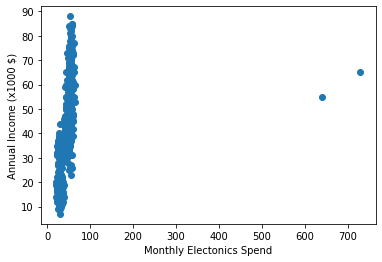

In [24]:
# scatterplt :: outlier확인  
plt.scatter(survey1["Annual Income (x1000 $)"], survey1["Monthly Electronics Spend"])
plt.xlabel("Monthly Electonics Spend")
plt.ylabel("Annual Income (x1000 $)")

In [25]:
survey1.drop(survey1[survey1["Annual Income (x1000 $)"] > 100].index, axis = 0, inplace = True)

#### 아웃라이어 제거 후 시각화 

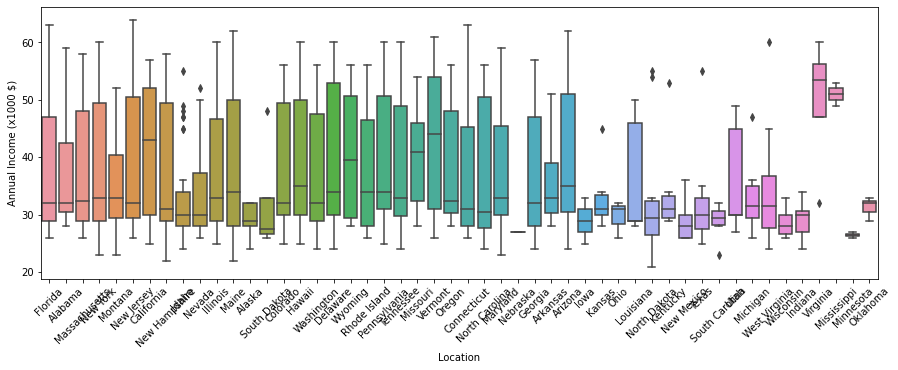

In [26]:
plt.subplots(figsize = (15, 5))
sns.boxplot(y = "Annual Income (x1000 $)", x = "Location", data = survey1)

plt.xticks(rotation = 45)
plt.show()

## 옵션 : boxplot(showflyers)

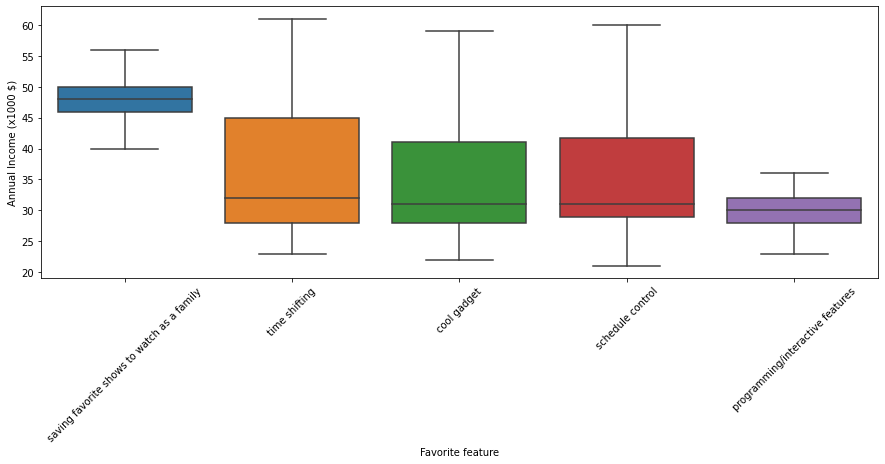

In [27]:
plt.subplots(figsize = (15, 5))
sns.boxplot(y = "Annual Income (x1000 $)", x = "Favorite feature", data = survey1, showfliers = False)

plt.xticks(rotation = 45)
plt.show()

#### 1.5 새로운 변수 만들기

#### 지역별 평균 소득 대비 개인소득

In [28]:
#state = pd.read_csv("desktop/income.csv")

#state.head()

### 주별 income per capital 
## 파생변수:: 지역별 평균 대비 연소득 calculate  

#d= dict([(i, a) for i, a in zip(state.State, state["Income per Capita"])])

#survey1["state_income_per_capital"] = survey1["Location"].replace(d)
#survey1["household_wealth"] = (survey1["Annual Income (x1000 $)"] * 1000) /(survey1["state_income_per_capital"])
#survey1["state_income_per_capital"].min(), survey1["state_income_per_capital"].max(), survey1["state_income_per_capital"].mean()

#### Location_divsion (구간화)

-미국 주 50개를 west, midwest, south, Northeast로 4가지로 구분 

In [29]:
survey1["Location_div"] = survey1["Location"]

In [30]:
survey1["Location_div"] = survey1["Location_div"].replace(["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey", "Pennsylvania"],  "Northeast")
survey1["Location_div"] = survey1["Location_div"].replace(["Ohio", "Michigan", "Indiana", "Wisconsin", "Illinois", "Minnesota", "Iowa", "Missouri", "North Dakota", "South Dakota", "Nebraska", "Kansas"], "Midwest")
survey1["Location_div"] = survey1["Location_div"].replace(["Delaware", "Maryland", "Virginia", "West Virginia", "Kentucky", "North Carolina", "South Carolina", "Tennessee", "Georgia", "Florida", "Alabama", "Mississippi", "Arkansas", "Louisiana", "Texas", "Oklahoma"], "South")
survey1["Location_div"] = survey1["Location_div"].replace(["Montana", "Idaho", "Wyoming", "Colorado", "New Mexico", "Arizona", "Utah", "Nevada", "California", "Oregon", "Washington", "Alaska", "Hawaii"], "West")                      

survey1["Location_div"].unique()

array(['South', 'Northeast', 'West', 'Midwest'], dtype=object)

#### Electronics 1회 구입 시 평균 가격

In [31]:
# electronic 1회 구입 시 평균 가격 = 1년 electronic spending / 1년당 구입횟수 
survey1["purchasing_avg_price"] = survey1["Annual spending on electronics"] / (12 / survey1["Purchasing Frequency (every x months)"]) 

#### TV 보유 여부 

In [32]:
# TV Viewing 0시간 ==> TV 미보유로 가정 
survey1["TV holder"] = np.where(survey1["TV Viewing (hours/day)"] == 0, 0, 1)

#### 소비성향 (과소비, 저축형 등) 

In [33]:
# 소비 성향 = 1년 지출 / 1년 income 
# 지수가 높을 수록 소비성향이 강함 
survey1["Consumption propensity"] = (survey1["Monthly Household Spend"] * 12) / survey1["Annual Income (x1000 $)"] 

#### Electronics 선호도 

In [34]:
#1달 Electronics 지출 / 1달 전체 지출
#지수가 높을 수록 Electronics 홀릭, 매니아 성향 
survey1["Electronics_preference"] = ((survey1["Monthly Electronics Spend"] *12) / (survey1["Monthly Household Spend"] *12))

#### 참고사항
하기항목은 비중이 적은 관계로 제외 
- 30-40대, 고학력, 고소득, 싱글 여성/남성  
- 60세 이상, 싱글

#### 데이터타입 재정의

In [35]:
survey1.dtypes

ID                                       float64
Gender                                    object
Coded Gender                              object
Marital Status                            object
Work Status                               object
Education                                 object
Ed coded                                  object
Annual Income (x1000 $)                  float64
Age                                      float64
Location                                  object
Purchasing Decision Maker                 object
Purchasing Location                       object
PL coded                                  object
Monthly Electronics Spend                float64
Annual spending on electronics           float64
Spending as % of income                  float64
Monthly Household Spend                  float64
Purchasing Frequency (every x months)    float64
Technology Adoption                       object
TV Viewing (hours/day)                   float64
Favorite feature    

In [36]:
survey1[["Ed coded", "PL coded", "FF coded"]] = survey1[["Ed coded", "PL coded", "FF coded"]].astype("int")

In [37]:
survey1["Purchasing Frequency (every x months)"] = 12/survey1["Purchasing Frequency (every x months)"]

#### 1.6 인코딩 + 더미변수 

In [38]:
# survey1["Purchasing Location"].unique()

# survey1["Purchasing Location"] = survey1["Purchasing Location"].replace({'mass-consumer electronics':1, 'specialty stores':2, 'retail':3,
#        'discount':4, 'web (ebay)':5})

# survey1["Favorite feature"].unique()

# survey1["Favorite feature"] = survey1["Favorite feature"].replace({'saving favorite shows to watch as a family':1, 'time shifting':2,
#        'cool gadget':3, 'schedule control':4,
#        'programming/interactive features':5})

# survey1["Purchasing Location"] = survey1["PL coded"]
# survey1["Favorite feature"] = survey1["FF coded"]

In [39]:
survey1["Gender"] = survey1["Coded Gender"]
survey1["Education"] = survey1["Ed coded"]

survey1.drop(["Coded Gender", "Ed coded", "PL coded", "FF coded"], axis = 1, inplace = True)

* 추가로 인코딩이 필요한 항목들을 변환해 준다. (레이블 인코딩의 경우 랜덤성이 있어 수동변환 해주었음)
* 수정사항 early : 1 , late : 0 

In [40]:
survey1[["Marital Status", "Work Status", "Purchasing Decision Maker", "Technology Adoption"]] = \
survey1[["Marital Status", "Work Status", "Purchasing Decision Maker", "Technology Adoption"]]\
.replace({"married":1, "single":0, "none":0, "professional":1, "family":1, "early":1, "late":0})

### 상관계수분석 

In [41]:
# 카테고리 변수들만 선택 
category = ["Gender", "Location", "Purchasing Decision Maker", "Purchasing Location", "Favorite feature", "Location_div"]

In [55]:
survey1.columns

Index(['ID', 'Gender', 'Marital Status', 'Work Status', 'Education',
       'Annual Income (x1000 $)', 'Age', 'Location',
       'Purchasing Decision Maker', 'Purchasing Location',
       'Monthly Electronics Spend', 'Annual spending on electronics',
       'Spending as % of income', 'Monthly Household Spend',
       'Purchasing Frequency (every x months)', 'Technology Adoption',
       'TV Viewing (hours/day)', 'Favorite feature', 'Location_div',
       'purchasing_avg_price', 'TV holder', 'Consumption propensity',
       'Electronics_preference'],
      dtype='object')

In [56]:
# 연속형 변수들만 선택한다. 
numeric = [i for i in survey1.columns if i not in category]

numeric = ["Annual Income (x1000 $)", 'Age', 'Monthly Electronics Spend',
           'Purchasing Frequency (every x months)', 'TV Viewing (hours/day)', 'purchasing_avg_price',
           'Consumption propensity', 'Electronics_preference', 'Annual spending on electronics']

#### Shapiro Test (정규성 검정) 

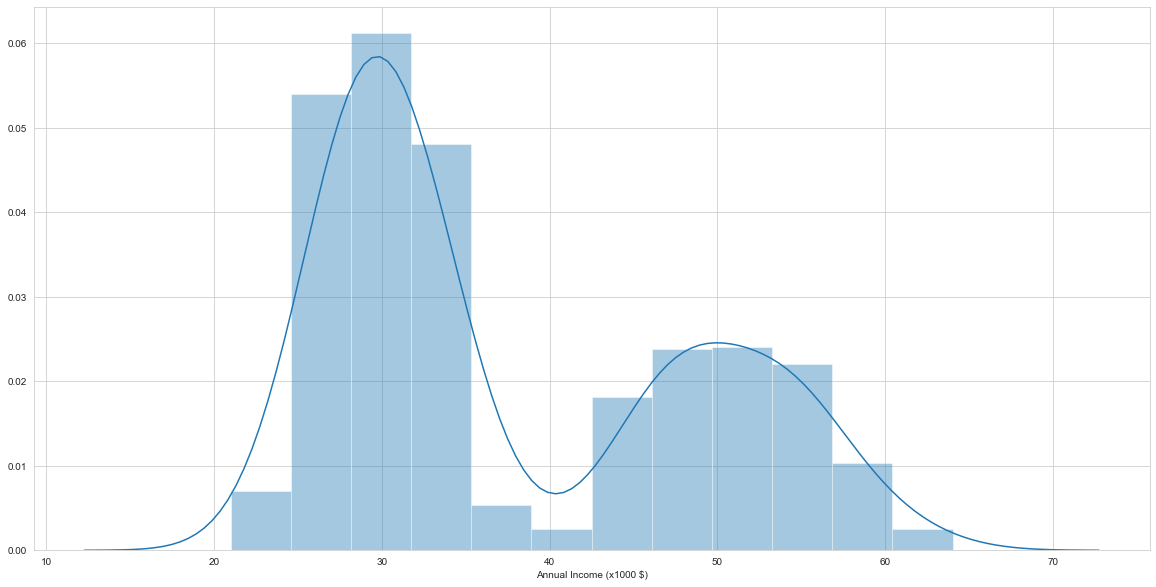

In [57]:
sns.set_style("whitegrid")
plt.subplots(figsize = (20, 10))
sns.distplot(survey1["Annual Income (x1000 $)"])
plt.show()

In [58]:
### Shapiro Test 

from scipy.stats import shapiro , normaltest , anderson , kstest

normal = []
notnormal = []
for var in numeric:
    stat, p  = shapiro(survey1[var].dropna().values)
    stat, p  = normaltest(survey1[var].dropna().values)
    alpha = 0.05
    if p > alpha :
        normal.append(var)
    else :
        notnormal.append(var)

In [59]:
# p-value가 0.05보다 작으므로 귀무가설을 기각, 즉 데이터는 정규성을 만족한다고 볼수없음 
# 정규성을 따르지 않는 변수들 
notnormal

['Annual Income (x1000 $)',
 'Age',
 'Monthly Electronics Spend',
 'Purchasing Frequency (every x months)',
 'TV Viewing (hours/day)',
 'purchasing_avg_price',
 'Consumption propensity',
 'Electronics_preference',
 'Annual spending on electronics']

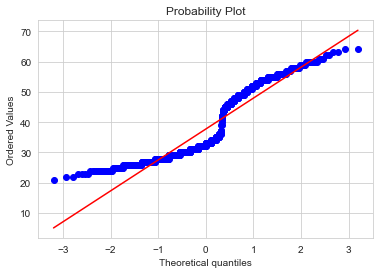

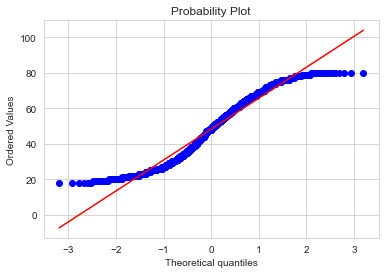

In [60]:
from scipy.stats import probplot
plt.figure()
probplot(survey1['Annual Income (x1000 $)'], plot=plt)

plt.figure()
probplot(survey1['Age'], plot=plt)

# plt.figure()
# probplot(survey1['Monthly Electronics Spend'], plot=plt)

# plt.figure()
# probplot(survey1['Consumption propensity'], plot=plt)

plt.show()

In [61]:
## 정규성을 만족하지 않는 변수 + 순서형 카테고리 변수 : spearnman 상관계수를 사용한다 

In [62]:
numeric = numeric + ["Work Status", "Education", "Technology Adoption"]

In [63]:
df_cor = survey1[numeric].corr(method = 'spearman')**2

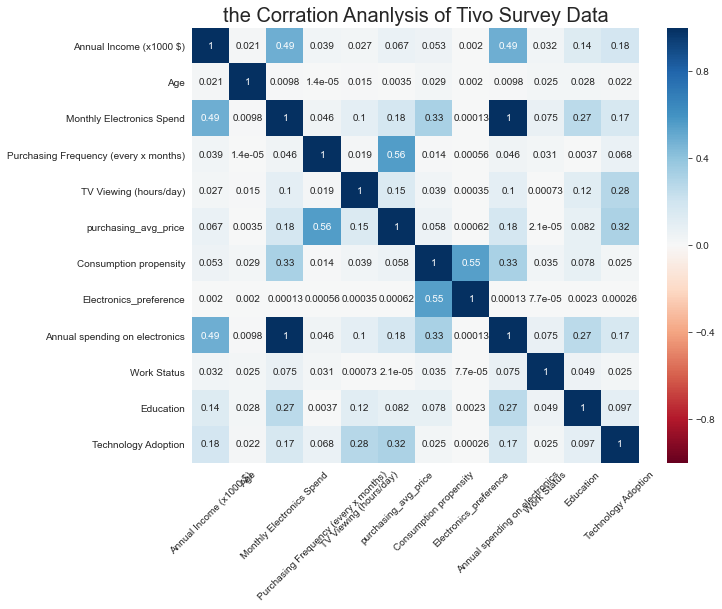

In [64]:
# 시각화 
plt.figure(figsize = (10, 8))
s = sns.heatmap(df_cor, 
               annot = True,
               cmap = "RdBu", 
               vmin = -1, 
               vmax = 1)

plt.title("the Corration Ananlysis of Tivo Survey Data", fontsize = 20)
s.set_xticklabels(s.get_xticklabels(), rotation = 45)

plt.show()

#### 중복컬럼 및  multicolinearity 관련 컬럼 제거 (0.8이상)
* annual spending/Month spending 
* Spending as % of income 
* "Monthly Household Spend"

In [139]:
## 우선 불필요 + 중복으로 보이는 spending as % of income은 삭제해 준다 ==> Consumption propensity 등으로 대체  

remove = ["Annual spending on electronics", "Spending as % of income", "Monthly Household Spend"]
survey1.drop(remove, 1, inplace = True)

#### 상관계수 높은 컬럼 제거 이후 Spearman  수행결과

In [140]:
df2 = survey1.corr(method = 'spearman')
df2.style.background_gradient(cmap="Blues")

,ID,Marital Status,Work Status,Education,Annual Income (x1000 $),Age,Purchasing Decision Maker,Monthly Electronics Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),purchasing_avg_price,TV holder,Consumption propensity,Electronics_preference
ID,1.000000,0.000836,0.000226,0.004416,0.000685,0.001937,0.000161,0.000724,0.000718,0.000039,0.000001,0.000471,0.000681,0.001157,0.001089
Marital Status,0.000836,1.000000,0.035295,0.009067,0.021019,0.076795,0.204025,0.001276,0.000698,0.040481,0.013306,0.000000,0.003508,0.017049,0.000525
Work Status,0.000226,0.035295,1.000000,0.049038,0.031514,0.024951,0.007377,0.074694,0.030735,0.024533,0.000732,0.000021,0.002269,0.034989,0.000077
Education,0.004416,0.009067,0.049038,1.000000,0.136240,0.028128,0.004615,0.269099,0.003681,0.096750,0.115729,0.082065,0.023505,0.078131,0.002256
Annual Income (x1000 $),0.000685,0.021019,0.031514,0.136240,1.000000,0.020555,0.130456,0.488580,0.038684,0.184032,0.026625,0.066551,0.004128,0.052883,0.001964
Age,0.001937,0.076795,0.024951,0.028128,0.020555,1.000000,0.051946,0.009824,0.000014,0.022398,0.015281,0.003523,0.001496,0.029188,0.001972
Purchasing Decision Maker,0.000161,0.204025,0.007377,0.004615,0.130456,0.051946,1.000000,0.049008,0.000526,0.118143,0.002302,0.014832,0.000661,0.000002,0.000037
Monthly Electronics Spend,0.000724,0.001276,0.074694,0.269099,0.488580,0.009824,0.049008,1.000000,0.045674,0.170704,0.101205,0.175929,0.016107,0.326989,0.000128
Purchasing Frequency (every x months),0.000718,0.000698,0.030735,0.003681,0.038684,0.000014,0.000526,0.045674,1.000000,0.067750,0.018984,0.559873,0.000045,0.014185,0.000564
Technology Adoption,0.000039,0.040481,0.024533,0.096750,0.184032,0.022398,0.118143,0.170704,0.067750,1.000000,0.284866,0.318521,0.027234,0.025110,0.000260


#### 카테고리 변수끼리 상관계수분석 : Cramer V 

1. 연속형 & 연속형 (모수적) - 피어슨 상관계수 (Pearson correlation coefficient)
2. 연속형 & 연속형 (비모수적) - 스피어만 순위 상관계수 (Spearman rank correlation coefficient)
3. 연송형(비모수적) & 순서형 - 스피어만 순위상관계수
4. 명목형 & 명목형 - cramer V

In [141]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in category:
    data_encoded[i]=label.fit_transform(survey1[i])

In [142]:
data_encoded.head()

,Gender,Location,Purchasing Decision Maker,Purchasing Location,Favorite feature,Location_div
0,1,8,1,1,2,2
1,1,0,0,1,2,2
2,1,20,1,3,4,1
3,1,31,1,1,2,1
4,0,25,0,1,2,3


In [143]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [144]:
rows= []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df

,Gender,Location,Purchasing Decision Maker,Purchasing Location,Favorite feature,Location_div
Gender,1.00,0.05,0.00,0.02,0.01,0.00
Location,0.05,1.00,0.13,0.08,0.09,1.00
Purchasing Decision Maker,0.00,0.13,1.00,0.22,0.26,0.01
Purchasing Location,0.02,0.08,0.22,1.00,0.33,0.01
Favorite feature,0.01,0.09,0.26,0.33,1.00,0.01
Location_div,0.00,1.00,0.01,0.01,0.01,1.00


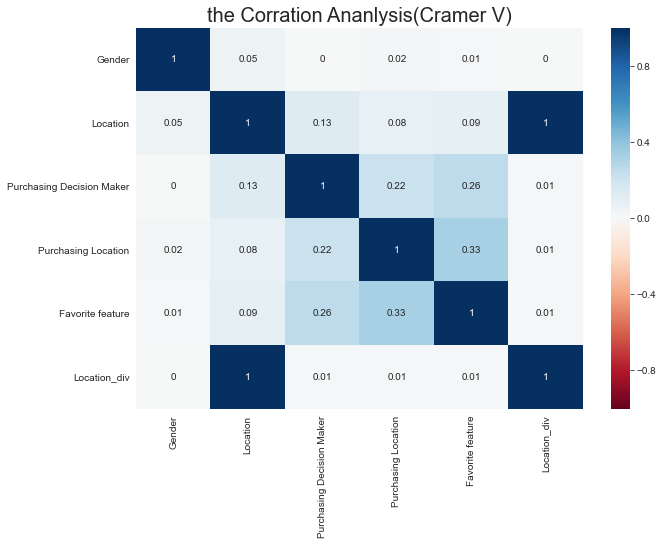

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    plt.figure(figsize = (10, 7))
    ax = sns.heatmap(df, 
               annot = True,
               cmap = "RdBu", 
               vmin = -1, 
               vmax = 1)

plt.title("the Corration Ananlysis(Cramer V)", fontsize = 20)
s.set_xticklabels(s.get_xticklabels(), rotation = 45)

plt.show()

In [146]:
# Location와 Location_div는 중복이므로 둘 중 하나 제외 



#### 더미 변수 
* 순서형이 아닌 카테고리형 변수들에 대한 더미변수 생성 
* Location, Purchasing Location, Favorite feature 

In [147]:
# 일부 카테고리컬 변수 더미생성 (Location 제회)
dummies = pd.get_dummies(survey1[["Location_div", "Purchasing Location", "Favorite feature"]])

# 생성한 더미변수 합해주기 
survey1 = pd.concat([survey1, dummies], axis = 1)

# 이전 컬럼은 제외 
survey1.drop(["Location", "Location_div", "Purchasing Location", "Favorite feature"], axis = 1, inplace = True)

In [148]:
survey1.columns

Index(['ID', 'Gender', 'Marital Status', 'Work Status', 'Education',
       'Annual Income (x1000 $)', 'Age', 'Purchasing Decision Maker',
       'Monthly Electronics Spend', 'Purchasing Frequency (every x months)',
       'Technology Adoption', 'TV Viewing (hours/day)', 'purchasing_avg_price',
       'TV holder', 'Consumption propensity', 'Electronics_preference',
       'Location_div_Midwest', 'Location_div_Northeast', 'Location_div_South',
       'Location_div_West', 'Purchasing Location_discount',
       'Purchasing Location_mass-consumer electronics',
       'Purchasing Location_retail', 'Purchasing Location_specialty stores',
       'Purchasing Location_web (ebay)', 'Favorite feature_cool gadget',
       'Favorite feature_programming/interactive features',
       'Favorite feature_saving favorite shows to watch as a family',
       'Favorite feature_schedule control', 'Favorite feature_time shifting'],
      dtype='object')

#### K-means Clustering 위한 리스케일링 (MinMaxScaler)

거리기반 모델은 단위의 영향을 받기 때문에 사전에 MinMaxScaler로 값을 0-1사이로 조정해 주었음 

In [149]:
from sklearn.preprocessing import MinMaxScaler

mns = MinMaxScaler()

mns.fit_transform(survey1)

array([[0.      , 1.      , 1.      , ..., 1.      , 0.      , 0.      ],
       [0.001001, 1.      , 0.      , ..., 1.      , 0.      , 0.      ],
       [0.002002, 1.      , 1.      , ..., 0.      , 0.      , 1.      ],
       ...,
       [0.997998, 1.      , 1.      , ..., 0.      , 1.      , 0.      ],
       [0.998999, 1.      , 1.      , ..., 1.      , 0.      , 0.      ],
       [1.      , 0.      , 1.      , ..., 0.      , 0.      , 0.      ]])

In [150]:
# ID로 인덱스 재설정 
survey1 = survey1.set_index("ID")

In [151]:
survey1[survey1.columns] = mns.fit_transform(survey1[survey1.columns])

In [152]:
survey1

,Gender,Marital Status,Work Status,Education,Annual Income (x1000 $),Age,Purchasing Decision Maker,Monthly Electronics Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),purchasing_avg_price,TV holder,Consumption propensity,Electronics_preference,Location_div_Midwest,Location_div_Northeast,Location_div_South,Location_div_West,Purchasing Location_discount,Purchasing Location_mass-consumer electronics,Purchasing Location_retail,Purchasing Location_specialty stores,Purchasing Location_web (ebay),Favorite feature_cool gadget,Favorite feature_programming/interactive features,Favorite feature_saving favorite shows to watch as a family,Favorite feature_schedule control,Favorite feature_time shifting
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,1.0,1.0,0.000000,0.651163,0.193548,1.0,0.345679,0.057283,0.0,0.142857,0.189803,1.0,0.386451,0.047297,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2.0,1.0,0.0,0.0,0.000000,0.581395,0.290323,0.0,0.345679,0.018003,0.0,0.714286,0.384747,1.0,0.454771,0.020892,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3.0,1.0,1.0,1.0,0.333333,0.860465,0.774194,1.0,0.703704,0.057283,1.0,0.000000,0.351328,0.0,0.204358,0.597875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4.0,1.0,1.0,0.0,1.000000,0.697674,0.967742,1.0,0.320988,0.025145,0.0,0.357143,0.305913,1.0,0.380556,0.020270,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5.0,0.0,0.0,0.0,0.000000,0.581395,0.548387,0.0,0.469136,0.000453,0.0,0.142857,0.901028,1.0,0.448611,0.112808,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.0,0.0,0.0,1.0,0.000000,0.186047,0.532258,1.0,0.098765,0.027356,1.0,0.142857,0.129820,1.0,0.216571,0.110360,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997.0,1.0,1.0,1.0,0.666667,0.255814,0.887097,0.0,0.098765,0.027356,1.0,0.000000,0.129820,0.0,0.275955,0.007775,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
998.0,1.0,1.0,1.0,0.000000,0.162791,0.758065,0.0,0.037037,0.071567,1.0,0.071429,0.041988,1.0,0.099504,0.205499,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-means clustering 수행 

In [153]:
survey1.columns

Index(['Gender', 'Marital Status', 'Work Status', 'Education',
       'Annual Income (x1000 $)', 'Age', 'Purchasing Decision Maker',
       'Monthly Electronics Spend', 'Purchasing Frequency (every x months)',
       'Technology Adoption', 'TV Viewing (hours/day)', 'purchasing_avg_price',
       'TV holder', 'Consumption propensity', 'Electronics_preference',
       'Location_div_Midwest', 'Location_div_Northeast', 'Location_div_South',
       'Location_div_West', 'Purchasing Location_discount',
       'Purchasing Location_mass-consumer electronics',
       'Purchasing Location_retail', 'Purchasing Location_specialty stores',
       'Purchasing Location_web (ebay)', 'Favorite feature_cool gadget',
       'Favorite feature_programming/interactive features',
       'Favorite feature_saving favorite shows to watch as a family',
       'Favorite feature_schedule control', 'Favorite feature_time shifting'],
      dtype='object')

#### Hierarchical Dendrogram 그리기 

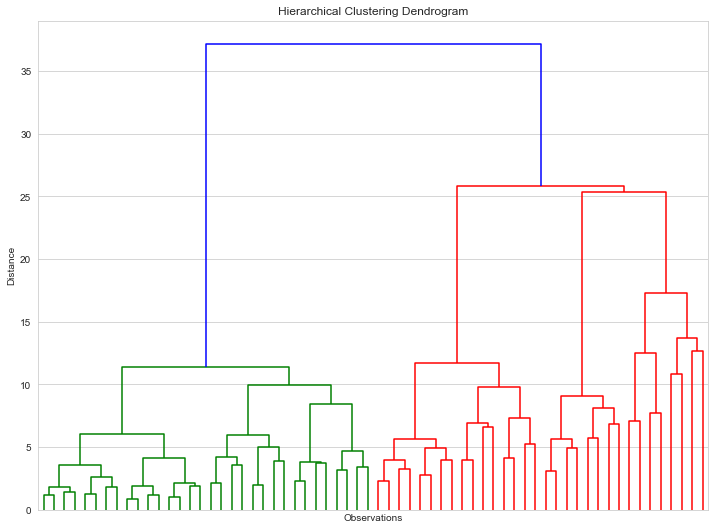

In [154]:
# Perform Hierarchical Clustering. The results are returned as a linkage matrix. 
hier_clust = linkage(survey1, method = 'ward')

# We plot the results from the Hierarchical Clustering using a Dendrogram. 
# We truncate the dendrogram for better readability. The level p shows only the last p merged clusters
# We also omit showing the labels for each point.
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.axhline(y=5000, color='r', linewidth=1, linestyle=':')
dendrogram(hier_clust,
           truncate_mode = 'level', 
           p = 5, 
           show_leaf_counts = False, 
           no_labels = True)
plt.show()

#### 엘보우 차트 

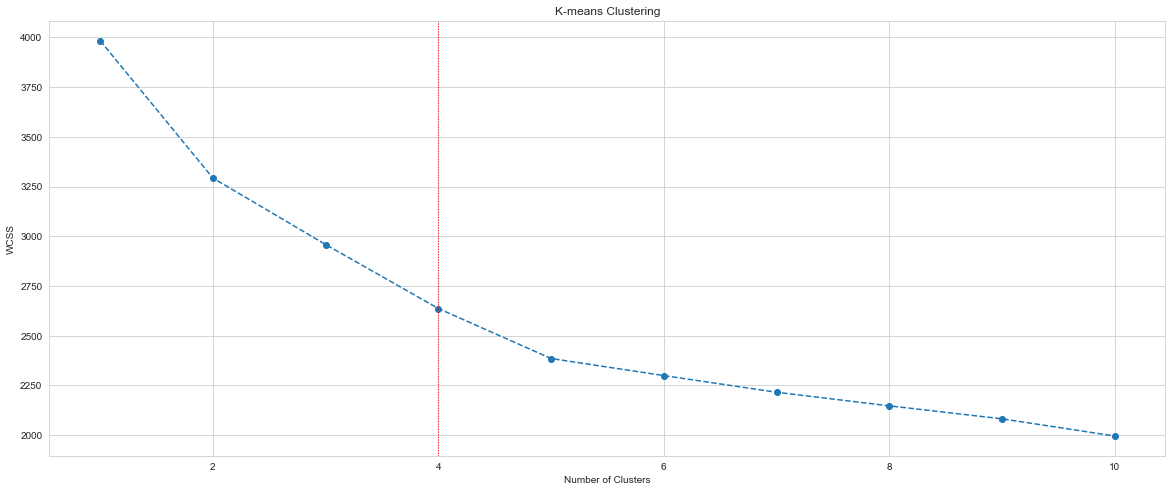

In [155]:
# Perform K-means clustering. We consider 1 to 10 clusters, so our for loop runs 10 iterations.
# In addition we run the algortihm at many different starting points - k means plus plus. 
# And we set a random state for reproducibility.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(survey1)
    wcss.append(kmeans.inertia_)
    
# Plot the Within Cluster Sum of Squares for the different number of clusters.
# From this plot we choose the number of clusters. 
# We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.
plt.figure(figsize = (20,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.axvline(x = 4, color='r', linewidth=1, linestyle=':')
plt.show()

### 세그멘테이션 나누기  (4개) 

In [156]:
# We run K-means with a fixed number of clusters. In our case 3.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

# We divide our data into the four clusters.
kmeans.fit(survey1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [157]:
# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans = survey1.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

#df_segm_kmeans.to_csv("desktop/tivo_revisit.csv")

#### Segmentation별로 그룹핑

In [158]:
# Calculate mean values for the clusters
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Gender,Marital Status,Work Status,Education,Annual Income (x1000 $),Age,Purchasing Decision Maker,Monthly Electronics Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),purchasing_avg_price,TV holder,Consumption propensity,Electronics_preference,Location_div_Midwest,Location_div_Northeast,Location_div_South,Location_div_West,Purchasing Location_discount,Purchasing Location_mass-consumer electronics,Purchasing Location_retail,Purchasing Location_specialty stores,Purchasing Location_web (ebay),Favorite feature_cool gadget,Favorite feature_programming/interactive features,Favorite feature_saving favorite shows to watch as a family,Favorite feature_schedule control,Favorite feature_time shifting
Segment K-means,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.702381,0.761905,1.0,0.404762,0.783499,0.512001,0.761905,0.633083,0.196027,1.0,0.079082,0.201254,0.815476,0.421723,0.262990,0.047619,0.452381,0.232143,0.267857,0.000000,0.0,0.000000,1.0,0.000000,0.339286,0.0,0.0,0.327381,0.333333
1,0.470000,0.900000,0.5,0.500000,0.630116,0.572661,0.900000,0.424753,0.017742,0.0,0.451786,0.526977,0.950000,0.327963,0.259520,0.065000,0.320000,0.235000,0.380000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000
2,0.518000,0.800000,0.5,0.090000,0.207116,0.549710,0.500000,0.122198,0.063233,1.0,0.073143,0.174492,0.756000,0.197369,0.264911,0.090000,0.360000,0.216000,0.334000,0.500000,0.0,0.500000,0.0,0.000000,0.340000,0.0,0.0,0.330000,0.330000
3,0.476923,0.076923,1.0,0.507692,0.205188,0.092432,0.000000,0.323932,0.070334,1.0,0.221978,0.344298,0.907692,0.419979,0.285571,0.161538,0.184615,0.330769,0.323077,0.330769,0.0,0.338462,0.0,0.330769,0.000000,1.0,0.0,0.000000,0.000000


In [159]:
#df_segm_analysis.to_csv("desktop/tivo_revisit_table.csv")

#### 스케일링 복원 (데이터 해석을 위해서 원래단위로 inverse하였음)

In [160]:
survey1['purchasing_avg_price']

ID
1.0       0.189803
2.0       0.384747
3.0       0.351328
4.0       0.305913
5.0       0.901028
            ...   
996.0     0.129820
997.0     0.129820
998.0     0.041988
999.0     0.398886
1000.0    0.004713
Name: purchasing_avg_price, Length: 998, dtype: float64

In [161]:
pd.options.display.max_columns = 50

In [162]:
df_segm_kmeans[survey1.columns] = mns.inverse_transform(df_segm_kmeans[survey1.columns])

df_segm_kmeans = df_segm_kmeans.round(2)

#df_segm_kmeans.to_csv("desktop/tivo_revisit_inverse.csv")


df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean().round(2)
df_segm_analysis

#df_segm_kmeans.to_csv("desktop/tivo_revisit_inverse_table.csv")

,Gender,Marital Status,Work Status,Education,Annual Income (x1000 $),Age,Purchasing Decision Maker,Monthly Electronics Spend,Purchasing Frequency (every x months),Technology Adoption,TV Viewing (hours/day),purchasing_avg_price,TV holder,Consumption propensity,Electronics_preference,Location_div_Midwest,Location_div_Northeast,Location_div_South,Location_div_West,Purchasing Location_discount,Purchasing Location_mass-consumer electronics,Purchasing Location_retail,Purchasing Location_specialty stores,Purchasing Location_web (ebay),Favorite feature_cool gadget,Favorite feature_programming/interactive features,Favorite feature_saving favorite shows to watch as a family,Favorite feature_schedule control,Favorite feature_time shifting
Segment K-means,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.70,0.76,1.0,1.21,54.69,49.74,0.76,58.28,2.55,1.0,1.11,481.73,0.82,39.72,0.39,0.05,0.45,0.23,0.27,0.00,0.0,0.00,1.0,0.00,0.34,0.0,0.0,0.33,0.33
1,0.47,0.90,0.5,1.50,48.10,53.50,0.90,41.40,0.46,0.0,6.32,1241.96,0.95,31.78,0.38,0.06,0.32,0.24,0.38,0.00,1.0,0.00,0.0,0.00,0.00,0.0,1.0,0.00,0.00
2,0.52,0.80,0.5,0.27,29.91,52.08,0.50,16.90,0.99,1.0,1.02,419.26,0.76,20.72,0.39,0.09,0.36,0.22,0.33,0.50,0.0,0.50,0.0,0.00,0.34,0.0,0.0,0.33,0.33
3,0.48,0.08,1.0,1.52,29.82,23.73,0.00,33.24,1.08,1.0,3.11,815.59,0.91,39.57,0.40,0.16,0.18,0.33,0.32,0.33,0.0,0.34,0.0,0.33,0.00,1.0,0.0,0.00,0.00


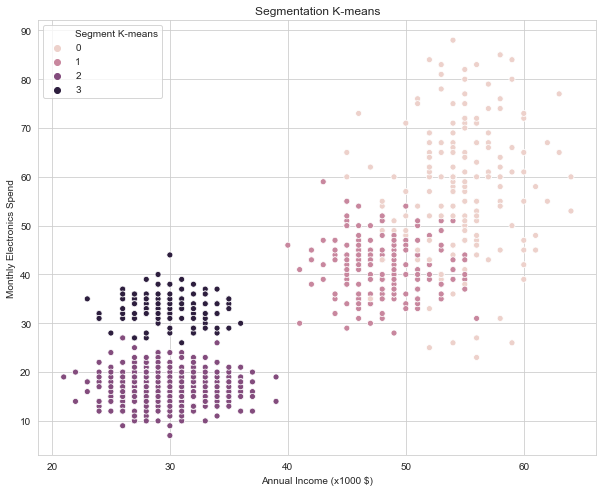

In [75]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_segm_kmeans["Annual Income (x1000 $)"]
y_axis = df_segm_kmeans['Monthly Electronics Spend']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans["Segment K-means"])
plt.title('Segmentation K-means')
plt.show()

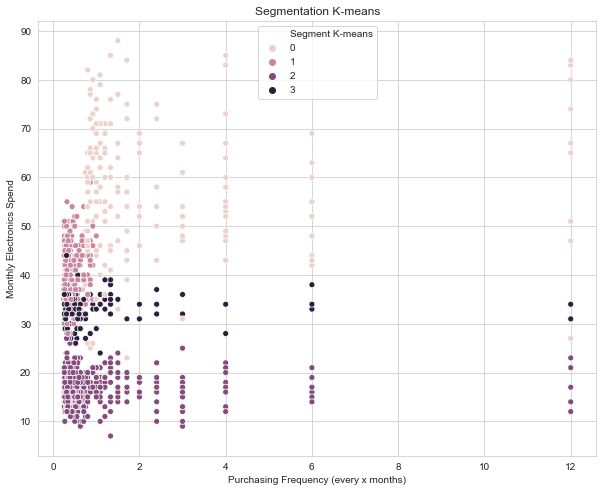

In [82]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_segm_kmeans["Purchasing Frequency (every x months)"]
y_axis = df_segm_kmeans['Monthly Electronics Spend']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans["Segment K-means"])
plt.title('Segmentation K-means')
plt.show()

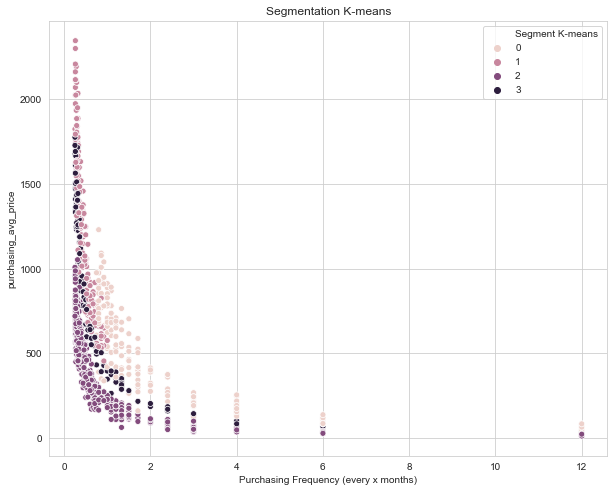

In [83]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_segm_kmeans["Purchasing Frequency (every x months)"]
y_axis = df_segm_kmeans['purchasing_avg_price']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans["Segment K-means"])
plt.title('Segmentation K-means')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


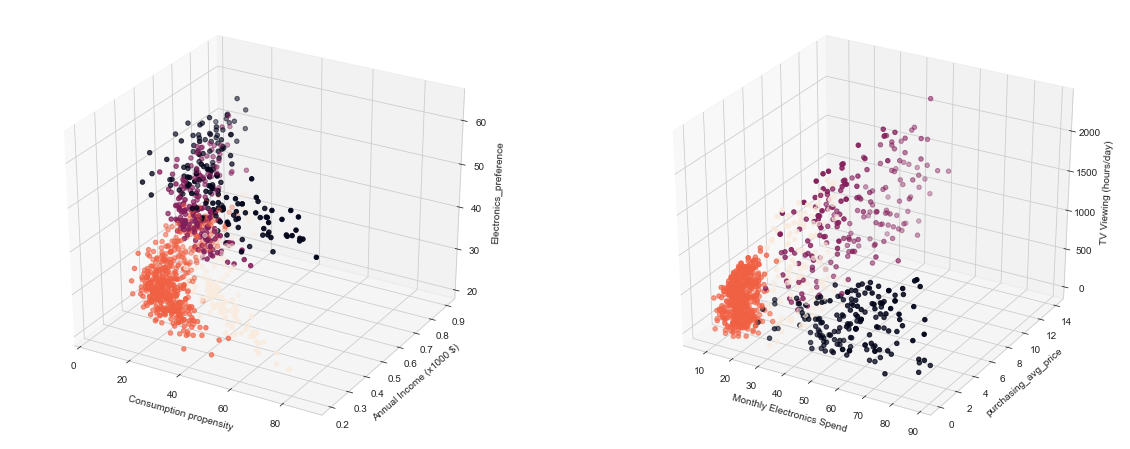

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate some dummy data
# Plot data
seg = df_segm_kmeans["Segment K-means"]

fig = plt.figure(figsize=(20,8))


time2 = df_segm_kmeans['Monthly Electronics Spend']
price2 = df_segm_kmeans['purchasing_avg_price']
day2 = df_segm_kmeans['TV Viewing (hours/day)']

ax = fig.add_subplot(122, projection='3d')
ax.scatter(time2, day2, price2, c = seg)
ax.set_xlabel('Monthly Electronics Spend')
ax.set_ylabel('purchasing_avg_price')
ax.set_zlabel('TV Viewing (hours/day)')

time = df_segm_kmeans['Consumption propensity']
price = df_segm_kmeans['Annual Income (x1000 $)']
day = df_segm_kmeans['Electronics_preference']
seg = df_segm_kmeans["Segment K-means"]

ax = fig.add_subplot(121, projection='3d')
ax.scatter(time, day, price, c = seg)
ax.set_xlabel('Consumption propensity')
ax.set_ylabel('Annual Income (x1000 $)')
ax.set_zlabel('Electronics_preference')

fig.show()

#### E.O.D

In [176]:
df_segm_kmeans

,Gender,Marital Status,Work Status,Education,Annual Income (x1000 $),Age,Purchasing Decision Maker,Monthly Electronics Spend,Purchasing Frequency (every x months),Technology Adoption,...,Purchasing Location_mass-consumer electronics,Purchasing Location_retail,Purchasing Location_specialty stores,Purchasing Location_web (ebay),Favorite feature_cool gadget,Favorite feature_programming/interactive features,Favorite feature_saving favorite shows to watch as a family,Favorite feature_schedule control,Favorite feature_time shifting,Segment K-means
ID,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,1.0,1.0,0.0,49.0,30.0,1.0,35.0,0.92,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2.0,1.0,0.0,0.0,0.0,46.0,36.0,0.0,35.0,0.46,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3.0,1.0,1.0,1.0,1.0,58.0,66.0,1.0,64.0,0.92,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4.0,1.0,1.0,0.0,3.0,51.0,78.0,1.0,33.0,0.55,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5.0,0.0,0.0,0.0,0.0,46.0,52.0,0.0,45.0,0.26,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6.0,0.0,1.0,0.0,1.0,31.0,72.0,0.0,14.0,0.38,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
7.0,1.0,1.0,1.0,0.0,33.0,62.0,0.0,18.0,0.29,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
8.0,1.0,1.0,0.0,0.0,29.0,30.0,0.0,23.0,1.33,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
9.0,1.0,1.0,1.0,0.0,57.0,60.0,1.0,74.0,12.00,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [192]:
feature = ['Gender', 'Marital Status', 'Work Status', 'Education',
       'Annual Income (x1000 $)', 'Age', 'Purchasing Decision Maker',
       'Monthly Electronics Spend', 'Purchasing Frequency (every x months)',
       'Technology Adoption', 'TV Viewing (hours/day)', 'purchasing_avg_price',
       'TV holder', 'Consumption propensity', 'Electronics_preference',
       'Location_div_Midwest', 'Location_div_Northeast', 'Location_div_South',
       'Location_div_West', 'Purchasing Location_discount',
       'Purchasing Location_mass-consumer electronics',
       'Purchasing Location_retail', 'Purchasing Location_specialty stores',
       'Purchasing Location_web (ebay)', 'Favorite feature_cool gadget',
       'Favorite feature_programming/interactive features',
       'Favorite feature_saving favorite shows to watch as a family',
       'Favorite feature_schedule control', 'Favorite feature_time shifting']

In [193]:
y = df_segm_kmeans["Segment K-means"]
X = df_segm_kmeans[feature]

### 예측모형 만들기 

* train/test set 분류 
* test_size = 0.3  
* train_set = 0.7

In [194]:
from sklearn.model_selection import train_test_split 

x_train, x_valid, y_train, y_test = train_test_split\
(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [195]:
x_train.shape, x_valid.shape, y_train.shape, y_test.shape

((698, 29), (300, 29), (698,), (300,))

### Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier(n_estimators=100)

In [197]:
rc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [198]:
preds = rc.predict(x_valid)

In [199]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, preds)

print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 1.0


In [200]:
feature_list = pd.concat([pd.Series(x_train.columns), pd.Series(rc.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:8]

,features_name,importance
7,Monthly Electronics Spend,0.220672
4,Annual Income (x1000 $),0.154869
22,Purchasing Location_specialty stores,0.096208
9,Technology Adoption,0.092370
25,Favorite feature_programming/interactive features,0.086172
26,Favorite feature_saving favorite shows to watc...,0.083198
20,Purchasing Location_mass-consumer electronics,0.050963
10,TV Viewing (hours/day),0.047595


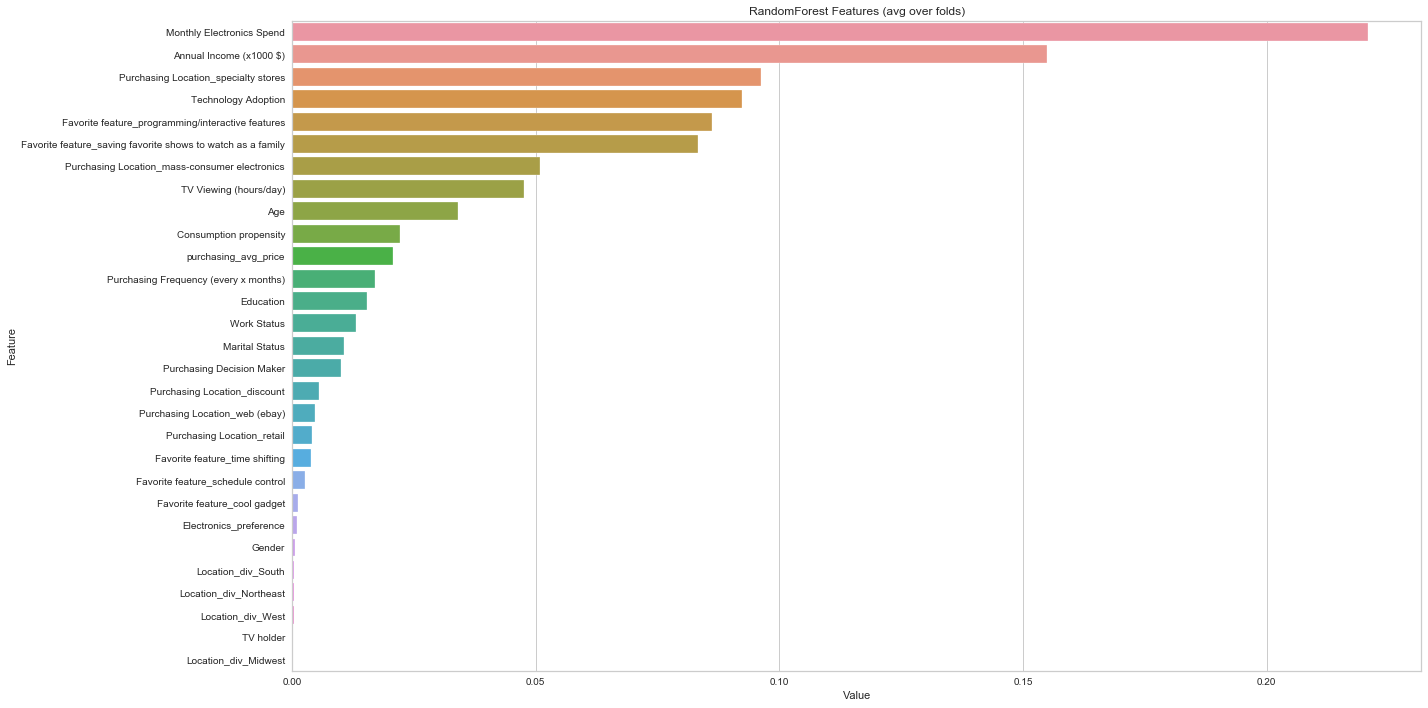

<Figure size 576x396 with 0 Axes>

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(rc.feature_importances_, x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForest Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')
plt.show()

# demographic 만으로 예측모형 만들기

* "Gender", "Marital Status", "Work Status", "Education", "Age" 변수만 활용

#### 랜덤포레스트 

In [150]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [151]:
X2 = X[["Gender", "Marital Status", "Work Status", "Education", "Age"]]

In [152]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3, stratify = y, random_state = 42)

In [153]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier(n_estimators=200, max_depth = 30, max_features = 0.8, n_jobs = -1)

k_fold = KFold(n_splits=5, shuffle=True, random_state=2)

score = cross_val_score(rc, x_train, y_train, cv=k_fold, n_jobs = -1)
score = score.mean()
print("Score= {0:.5f}".format(score))

predicted = cross_val_predict(rc, x_train, y_train, cv=k_fold, method='predict_proba')

In [155]:
X.shape, y.shape

((998, 29), (998,))

#### lightgbm 

In [156]:
from lightgbm import LGBMClassifier
lb = LGBMClassifier(n_estimators= 50, 
                    learning_rate = 0.1, 
                    num_leaves= 35, # 노드 개수. 많이지면 많이질수록 더 많이 학습한다. #한쪽만 계속해서 학습하는게 가능하다. 31개 디폴트.
                    colsample_bytree = 0.7, # 모든 컬럼이 아니라 일정 컬럼만 쓴다. 
                    subsample = 0.75, # 행을 0.75 샘플링 
                    random_state = 42)

score = cross_val_score(lb, x_train, y_train, cv=k_fold)
score = score.mean()
print("Score= {0:.5f}".format(score))

predicted2 = cross_val_predict(lb, x_test, y_test, cv=k_fold, method='predict_proba')

Score= 0.74497


In [157]:
lb.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=35, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

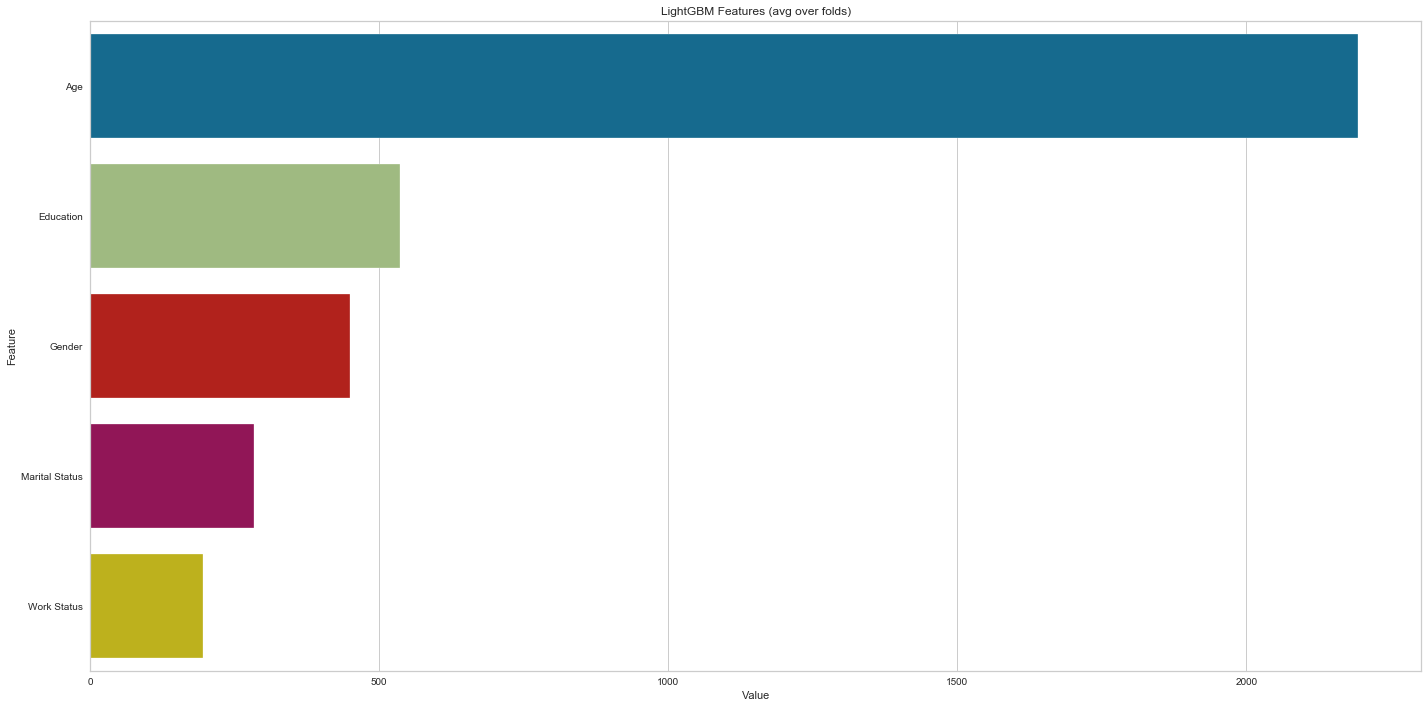

<Figure size 576x396 with 0 Axes>

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lb.feature_importances_, x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

#### lightgbm ROC CURVE

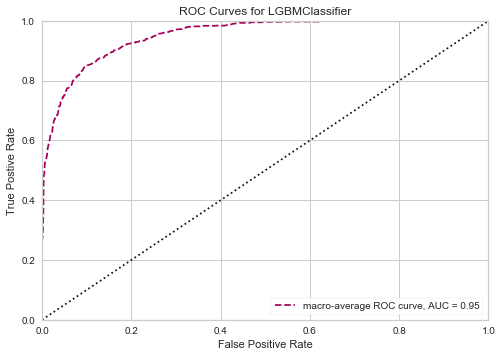

In [159]:
from yellowbrick.classifier import ROCAUC
 
visualizer = ROCAUC(lb, classes=[0, 1, 2, 3], micro=False, macro=True, per_class=False)

visualizer.fit(x_train, y_train)
visualizer.score(x_train, y_train)
visualizer.show()

plt.show()

In [160]:
accuracy_score(predicted2.argmax(1), y_test)

0.7566666666666667

#### 회귀모형 

In [161]:
from sklearn.linear_model import RidgeClassifier 

rg = RidgeClassifier(alpha = 0.5)
score = cross_val_score(rg, x_train, y_train, cv=k_fold)
score = score.mean()
print("Score= {0:.5f}".format(score))

Score= 0.65913


#### KNN 

In [162]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

score = cross_val_score(knn, x_train, y_train, cv=k_fold)
score = score.mean()
print("Score= {0:.5f}".format(score))

predicted3 = cross_val_predict(knn, x_test, y_test, cv=k_fold, method = "predict_proba")

Score= 0.66200


#### XGBoost

In [163]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate = 0.025, 
                    max_depths = 6,
                    colsample_bytree = 0.8,
                    subsample = 0.8, 
                   n_estimators = 180)

score = cross_val_score(xgb, x_train, y_train, cv=k_fold)

print("Score= {0:.5f}".format(score))

predicted4 = cross_val_predict(xgb, x_test, y_test, cv=k_fold, method = "predict_proba")

Score= 0.75357


In [164]:
print(accuracy_score(y_test, predicted4.argmax(1)))
#log_loss(y_test, predicted4)

0.7666666666666667


#### Decision Tree

In [165]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [166]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dmba import plotDecisionTree, classificationSummary, regressionSummary, gainsChart, liftChart

In [167]:
dt = DecisionTreeClassifier(max_depth = 20, min_samples_split = 50, min_impurity_decrease = 0.01)
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [168]:
print(f"Tree has {dt.tree_.node_count} nodes")

Tree has 15 nodes


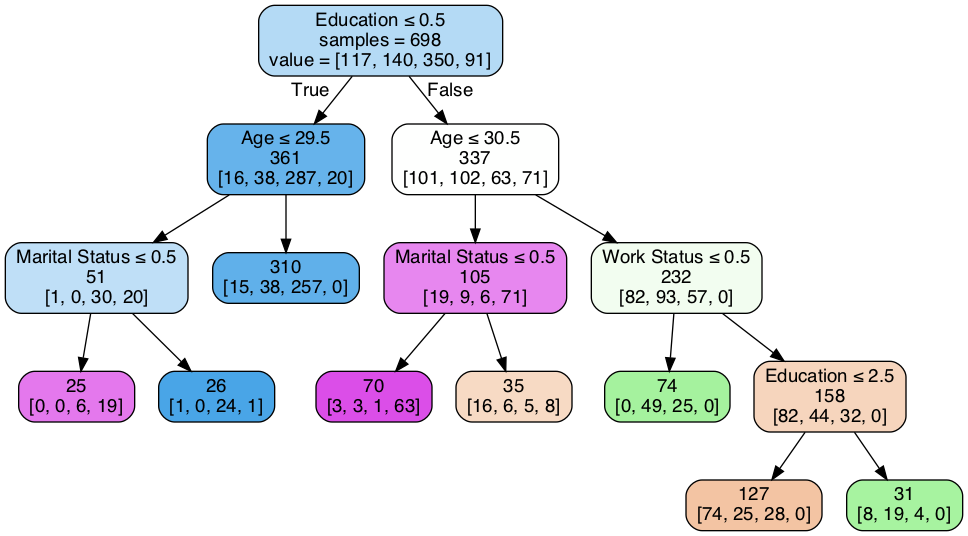

In [169]:
plotDecisionTree(dt, feature_names = x_train.columns)

In [170]:
x_train

,Gender,Marital Status,Work Status,Education,Age
ID,,,,,
371.0,0.0,1.0,1.0,0.0,63.0
129.0,0.0,0.0,0.0,0.0,72.0
91.0,0.0,1.0,0.0,1.0,55.0
534.0,1.0,1.0,0.0,1.0,37.0
473.0,1.0,1.0,1.0,1.0,55.0
625.0,1.0,1.0,0.0,0.0,63.0
763.0,0.0,1.0,0.0,3.0,51.0
203.0,0.0,1.0,1.0,0.0,63.0
734.0,1.0,1.0,1.0,2.0,67.0


In [190]:
from sklearn.ensemble import ExtraTreesClassifier

etc_model = ExtraTreesClassifier()
etc_model.fit(X, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(x_train.columns), pd.Series(lb.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:8]

[0.00053708 0.04086811 0.02815888 0.02738712 0.08001283 0.03270954
 0.02106894 0.08499604 0.00590109 0.10133758 0.02003642 0.0071816
 0.00028356 0.01927926 0.00091349 0.00085542 0.00070441 0.00041075
 0.00053525 0.01174397 0.07227761 0.05824199 0.13370262 0.01339631
 0.01190187 0.06226976 0.14822901 0.00494957 0.01010991]


,features_name,importance
4,Annual Income (x1000 $),2193.0
3,Education,536.0
0,Gender,450.0
1,Marital Status,284.0
2,Work Status,195.0
5,Age,NaN
6,Purchasing Decision Maker,NaN
7,Monthly Electronics Spend,NaN


In [191]:
feature_list = pd.concat([pd.Series(x_train.columns), pd.Series(rc.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:8]

,features_name,importance
7,Monthly Electronics Spend,0.188508
4,Annual Income (x1000 $),0.150737
22,Purchasing Location_specialty stores,0.098874
25,Favorite feature_programming/interactive features,0.094222
20,Purchasing Location_mass-consumer electronics,0.081330
9,Technology Adoption,0.080395
26,Favorite feature_saving favorite shows to watc...,0.073210
10,TV Viewing (hours/day),0.039389
